# Homework 2 

*Student: Dayana Valentina Gonzalez Vargas*

## Libraries

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import math

**1. Write down a code able to read the data that is attached and create a doubly-connected edge list for the simple polygon.**

## Doubly-connected edge list
### Main Classes

- **Class Vertex**

In [6]:
class vertex:
    def __init__(self, x , y, name):
        self.x = x ## Coordinate X
        self.y = y ## Coordinate Y
        self.name = name ## Name's vertex
        self.edge_inci = None ## Incident Edge
        self.type = None #Type vertex Start,end,regular,merge o split

    ## Add Incident Edge
    def add_edge_inci(self,e):
        self.edge_inci = e

    ##Relation of order binary -> 0 below, -> 1 above.
    def r_order_binary(self,q):
        if self.y > q.y:
            return 0
        elif self.y == q.y:
            if self.x < q.x:
                return 0
            else:
                return 1
        else:
            return 1
    
    #Relation of order, Output: point
    def r_orden(self,q):
        if self.y > q.y:
            point = self
        elif self.y == q.y:
            if self.x < q.x:
                point = self
            else:
                point = q
        else:
            point = q
        return point


- **Class Edge**

In [7]:
class half_edge:
    def __init__(self,start,end,name):
        self.origin = start #Origin
        self.queue = end #Queue
        self.name = name #Name
        self.next = None #Next
        self.prev = None #Prev
        self.face = None #Incident Face
        self.twin = twin(self) #General Twin
        self.twin_save = None  #Save Twin

    global twin
    def twin(self): #General Twin
        return self.queue, self.origin
    
    #Save Twin
    def add_twin_save(self,t):
        self.twin_save = t #Twin have to be object Edge
    
    def add_next(self,n):
        self.next = n #Next have to be object Edge
    
    def add_prev(self,pv):
        self.prev = pv #Prev have to be object Edge

    def add_face(self,f):
        self.face = f #Face have to be object Face  

    def add_twin(self,t):
          self.twin = t # Twin have to be object Edge

- **Class Face**

In [8]:
class face:
    def __init__(self,n):
        self.name = n #Name
        self.exterior = 'None' #External border
        self.interior = 'None' #Internal border

## we must take into account this fuction:
- Cross product
- Orientation

In [9]:
# P0 : Point prev origin
# P1 : Point edge origin
# P2 : Point next origin
def Producto_Cruz(P0,P1,P2):
    d = ((P1.x-P0.x)*(P2.y-P0.y))-((P2.x-P0.x)*(P1.y-P0.y))
    return d

In [10]:
# P0 : Point prev origin
# P1 : Point edge origin
# P2 : Point next origin
#Orientation
def orientacion(P0,P1,P2):
    d = Producto_Cruz(P0,P1,P2)
    if d>0:
        a = True
        print("P2 se hace un giro en sentido horario de P1")
    else:
        a = False
        print("P2 esta girando en sentido Anti horario de P1")
    return a 

## Class DCLE
For this class we will take into account the objects defined above, as well as concepts seen in class such as the following:
### Conceptos
* **Arista incidente:** Si un vértice es el punto final de una arista, entonces
decimos que el vértice y la arista son incidentes
* Una cara y una arista de su frontera son incidentes, y una cara y un vértice de su frontera son incidentes.
* Una lista de aristas doblemente conectadas contiene una lista por caras, nodos y semi-aristas.
* Recorrer una cara en el sentido contrario a las agujas del reloj.
* Si una semi-aristae tiene v como origen y w como destino, entonces su gemela Twin(e) tiene w como origen y v como destino.
* Para llegar al límite de una cara basta con almacenar un puntero en el registro de caras a una media arista arbitraria que delimite la cara.
* **límites de los agujeros de una cara:** si se recorren en sentido contrario a las agujas del reloj, la cara queda a la derecha.
* Another consequence is that twin half-edges always have opposite orientations
* Frontera interior giro en sentido antihorario
* Frontera exterior giro en setido horario

In [11]:
class DCEL():
    # We insert only the list object vertex
    def __init__(self,vertex):
        self.list_edge = []
        self.list_vertex = vertex
        self.list_face = []

    #----------------------------------------------------------------
    #Generate the twins with their characteristics
    def _add_twin(self):
        #Lists
        twins = []
        twins_sorted = []

        #General twins
        edges_copy = self.list_edge.copy()
        for i in range(len(edges_copy)):
            t_start, t_end = twin(edges_copy[i])
            tn = half_edge(t_start,t_end,'te'+str(i+1))
            tn.add_twin_save(self.list_edge[i])
            twins.append(tn)

        print('Entro2')
        
        # Organizamos para que quede de manera ciclica y agremaos el next
        origen = twins[0].queue
        a = True
        while(a != False):
            edge_next = [i for i in twins  if i.origin == origen]
            twins_sorted.append(edge_next[0])
            origen = edge_next[0].queue
            if len(twins_sorted) == len(twins):
                a = False


        index = len(self.list_edge) - len(twins_sorted)
        twin_Already = []
        # Add Next and Prev
        for i in range(0,len(twins_sorted)+1):
            if i == 0:
                self.list_edge.append(twins_sorted[0])
            else:
                prev_twin = self.list_edge[-1]
                if i == len(twins_sorted):
                    index = len(self.list_edge) - len(twins_sorted)
                    prev_twin.add_next(self.list_edge[index])
                    self.list_edge[index].add_prev(prev_twin)
                    self.list_edge[-1] = prev_twin
                    twin_Already.append(self.list_edge[index])
                else:
                    twins_sorted[i].add_prev(prev_twin)
                    prev_twin.add_next(twins_sorted[i])
                    self.list_edge.append(twins_sorted[i])
                    twin_Already.append(twins_sorted[i])
        
        # Add to list of edges
        for i in range(len(self.list_edge)):
            start_t, end_t = twin(self.list_edge[i])
            for j in twin_Already:
                if (j.origin == start_t) and (j.queue == end_t):
                    self.list_edge[i].add_twin_save(j)

    #------------------------------------------------------------------------------
    #add objects next and prev
    def _add_next(self):
        for i in range(len(self.list_edge)):
            if i == len(self.list_edge)-1:
                self.list_edge[i].add_next(self.list_edge[0])
            else:
                self.list_edge[i].add_next(self.list_edge[i+1])   
    
    def _add_prev(self):
        for i in range(len(self.list_edge)):
            if i == 0:
                self.list_edge[i].add_prev(self.list_edge[len(self.list_edge)-1])
            else:
                self.list_edge[i].add_prev(self.list_edge[i-1])
    #------------------------------------------------------------------------------

    #General list of edges
    def create_half_edge(self):
        print('Entro')
        for i in range(len(self.list_vertex)): 
            name_edge = 'e'+str(i+1)
            if i == (len(self.list_vertex)-1):
                e = half_edge(self.list_vertex[i], self.list_vertex[0], name_edge)
                self.list_vertex[i].add_edge_inci(e)
            else: 
                e = half_edge(self.list_vertex[i], self.list_vertex[i+1], name_edge)
                self.list_vertex[i].add_edge_inci(e)

            self.list_edge.append(e)

        self._add_next()
        self._add_prev()
        self._add_twin()

    #-----------------------------------------------------------------------------------
    ##El mas arriba a la izq
    def p_up(self):
        p = self.list_vertex[0]
        for i in range(len(self.list_vertex)):
            if self.list_vertex[i] == p:
                p = p.r_orden(self.list_vertex[i+1])
            else:
                p = p.r_orden(self.list_vertex[i])
        return p
    
    #-----------------------------------------------------------------------------------
    #generar un ciclo 
    def cicle(self,e,f):
        e.add_face(f)
        edge = e
        e = e.next
        while(e != edge):
            e.add_face(f)
            e = e.next
    
    #----------------------------------------------------------------------------------
    #General list Face
    def create_face(self):
        Inter,exter = face('I'),face('E')
        
        #Punto más arriba a la izquierda 
        p = self.p_up()
        idex = 0
        # Asegurarse de tomar la arista e que tenga ese punto como origen y que no sea la gemela
        for i in self.list_edge:
            if (p == i.origin) and (i.name == 'e'):
                idex = self.list_edge.index(i)
        
        e_inc = self.list_edge[idex]
        start_t,end_t = twin(e_inc)
        e_twin = None
        #Encontrar el gemelo
        for i in self.list_edge:
            if (i.origin == start_t) and (i.queue == end_t):
                e_twin =i

        a = orientacion(e_inc.origin,e_inc.next.origin,e_inc.next.queue)
        if a == True:
            Inter.interior = e_inc
            self.cicle(e_inc,Inter)
            exter.exterior = e_twin
            self.cicle(e_twin,exter)
            print('Las aristas que conformar dicho ciclo son frontera de cara interior')
        else:
            exter.exterior = e_inc
            self.cicle(e_inc,exter)
            Inter.interior = e_twin
            self.cicle(e_twin,exter)
            print('Las aristas que conformar dicho ciclo son frontera de cara exterior')
            
        self.list_face.append(Inter)
        self.list_face.append(exter)

    #-----------------------------------------------------------------------------------   
    #  General the list of face and half-edge
    def create_edge_face(self):
        self.create_half_edge()
        self.create_face()

**General Vertex**

In [12]:
def general_vertex(P):
    list_vertex = []
    for i in range(len(P)):
        name = "V"+str(i+1)
        v = vertex(P[i][0],P[i][1], name)
        list_vertex.append(v)
    return list_vertex

### Part READ FILE

In [13]:
# Read and save points
file = open("datos.txt")
P = file.read().split('), (')
file.close()

#Delete the (( start, end ))
P[0]= P[0][2:]
P[-1] = P[-1][:-2]

#take vertex for polynomial
P_new = []
for i in P:
    point = i.split(',')
    P_new.append([float(point[0]),float(point[1])])

print('Polynomial Points')
print(P_new[:-1])

    

Polynomial Points
[[9.0, 0.5], [8.0, 6.0], [7.0, -3.0], [6.0, 3.0], [4.0, -4.0], [2.0, -3.0], [3.0, 4.0], [4.0, 2.5], [5.0, 12.0], [7.0, 8.5], [8.0, 12.0], [9.5, 11.0], [11.0, 15.0], [13.0, 13.0], [12.0, 10.0], [13.0, 3.0], [11.0, 4.0], [10.0, -1.0]]


**Result 1.**

In [14]:
#General list vertex
lv = general_vertex(P_new[:-1])

#General DCEL
DCEL1 = DCEL(lv)
DCEL1.create_edge_face()

Entro
Entro2
P2 se hace un giro en sentido horario de P1
Las aristas que conformar dicho ciclo son frontera de cara interior


## List vertex

In [15]:
print('vertex','Incident edge', 'coordinate')
for i in range(len(DCEL1.list_vertex)):
    print(DCEL1.list_vertex[i].name,DCEL1.list_vertex[i].edge_inci.name,[DCEL1.list_vertex[i].x,DCEL1.list_vertex[i].y])

vertex Incident edge coordinate
V1 e1 [9.0, 0.5]
V2 e2 [8.0, 6.0]
V3 e3 [7.0, -3.0]
V4 e4 [6.0, 3.0]
V5 e5 [4.0, -4.0]
V6 e6 [2.0, -3.0]
V7 e7 [3.0, 4.0]
V8 e8 [4.0, 2.5]
V9 e9 [5.0, 12.0]
V10 e10 [7.0, 8.5]
V11 e11 [8.0, 12.0]
V12 e12 [9.5, 11.0]
V13 e13 [11.0, 15.0]
V14 e14 [13.0, 13.0]
V15 e15 [12.0, 10.0]
V16 e16 [13.0, 3.0]
V17 e17 [11.0, 4.0]
V18 e18 [10.0, -1.0]


## List Half-edge

In [21]:
print('vertex','Incident edge','next edge','prev edge', 'Face','twin', 'coordinate')
for i in range(len(DCEL1.list_edge)):
    print(DCEL1.list_edge[i].origin.name,DCEL1.list_edge[i].name,
          DCEL1.list_edge[i].next.name,DCEL1.list_edge[i].prev.name,
          DCEL1.list_edge[i].face.name, DCEL1.list_edge[i].twin_save.name,[DCEL1.list_edge[i].origin.x,
                                                                           DCEL1.list_edge[i].origin.y],
                                                                           [DCEL1.list_edge[i].queue.x,
                                                                            DCEL1.list_edge[i].queue.y] )

vertex Incident edge next edge prev edge Face twin coordinate
V1 e1 e2 e18 I te1 [9.0, 0.5] [8.0, 6.0]
V2 e2 e3 e1 I te2 [8.0, 6.0] [7.0, -3.0]
V3 e3 e4 e2 I te3 [7.0, -3.0] [6.0, 3.0]
V4 e4 e5 e3 I te4 [6.0, 3.0] [4.0, -4.0]
V5 e5 e6 e4 I te5 [4.0, -4.0] [2.0, -3.0]
V6 e6 e7 e5 I te6 [2.0, -3.0] [3.0, 4.0]
V7 e7 e8 e6 I te7 [3.0, 4.0] [4.0, 2.5]
V8 e8 e9 e7 I te8 [4.0, 2.5] [5.0, 12.0]
V9 e9 e10 e8 I te9 [5.0, 12.0] [7.0, 8.5]
V10 e10 e11 e9 I te10 [7.0, 8.5] [8.0, 12.0]
V11 e11 e12 e10 I te11 [8.0, 12.0] [9.5, 11.0]
V12 e12 e13 e11 I te12 [9.5, 11.0] [11.0, 15.0]
V13 e13 e14 e12 I te13 [11.0, 15.0] [13.0, 13.0]
V14 e14 e15 e13 I te14 [13.0, 13.0] [12.0, 10.0]
V15 e15 e16 e14 I te15 [12.0, 10.0] [13.0, 3.0]
V16 e16 e17 e15 I te16 [13.0, 3.0] [11.0, 4.0]
V17 e17 e18 e16 I te17 [11.0, 4.0] [10.0, -1.0]
V18 e18 e1 e17 I te18 [10.0, -1.0] [9.0, 0.5]
V1 te18 te17 te1 E e18 [9.0, 0.5] [10.0, -1.0]
V18 te17 te16 te18 E e17 [10.0, -1.0] [11.0, 4.0]
V17 te16 te15 te17 E e16 [11.0, 4.0] [13.0, 

## List face

In [22]:
print('Name Face','Inter', 'External')
print(DCEL1.list_face[0].name, 'None', DCEL1.list_face[0].interior.name)
print(DCEL1.list_face[1].name, DCEL1.list_face[1].exterior.name, 'None')

Name Face Inter External
I None e1
E te1 None


## Polygon graph

In [18]:
def grafic(P):
    xcor = []
    ycor = []
    for n in P:
        xcor.append(n.x)
        ycor.append(n.y)
    
    xcor.append(xcor[0])
    ycor.append(ycor[0])

    plt.scatter(xcor,ycor)
    for n in P:
        plt.annotate(n.name, xy = (n.x, n.y), xytext=(n.x, n.y))
    plt.plot(xcor,ycor)
    plt.show()

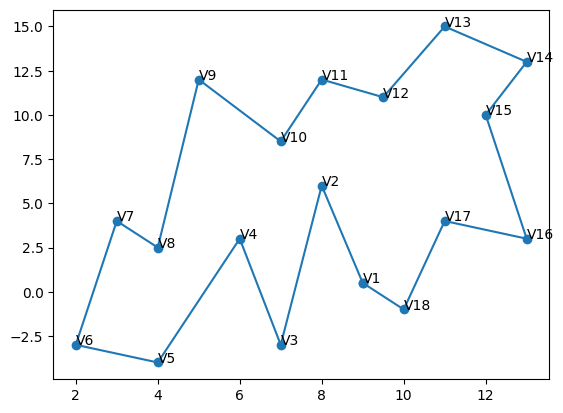

In [20]:
grafic(DCEL1.list_vertex)

**2. Implement an algorithm able to split the given polygon in to y-monotone polygons. Give your answer in terms of doubly-connected edge lists. Plot your result.**

- This functions help to find the vertex type:

In [23]:
def neighbors(v):
    e = v.e_inc # Tomamos la arista incidente
    e_prev = e.prev #Tomamos la semi-arista previa
    e_next = e.next #Tomamos la semi-arista next
    v1 = e_prev.origin #Tomamos el vertice que da origen a la semi-arista prev
    v2 = e_next.origin # Tomamos el vetice final de la semi arista next
    pos1 = v.r_order_binary(v1) #Vemos la posicion de v1 con respecto a v
    pos2 = v.r_order_binary(v2) #Vemos la posicion de V2 con respecto a v
    print(pos1,pos2)
    if pos1 != pos2:
        print('uno arriba y otro abajo')
        return 1 #Esta uno arriba y otro abajo
    else:
        if pos1 == 1 and pos2 == 1:
            print('Ambos estan arriba')
            return 2 #Ambos estan abajo
        elif pos1 == 0 and pos2 == 0:
            print('Ambos estan abajo')
            return 3 #Ambos estan abajo

In [24]:
def type_vertex(v): 
    pos = neighbors(v)
    print(pos)
    print(orientacion(v.e_inc.origin,v.e_inc.prev.origin,v.e_inc.next.origin))
    if pos == 3: #Estan por debajo
        if orientacion(v.e_inc.origin,v.e_inc.prev.origin,v.e_inc.next.origin): #TRUE - antihorario
            v.type = 'start'
        else: #False - horario
            v.type = 'split'
    elif pos == 2: #Estan por arriba
        if orientacion(v.e_inc.origin,v.e_inc.prev.origin,v.e_inc.next.origin): #TRUE - antihorario
            v.type = 'end'
        else: #False - horario
            v.type = 'merge'
    else:
        v.type = 'regular'
    return v

- This fuction add a Diagonal to the polygon: 

In [ ]:
def check_cycle(ea,eb):
    pass

In [27]:
#input: Vertex a, Vertex b and Doubly-connected edge list
#Output: Update Doubly-connected edge list
def add_diagonal(Va,Vb,DCEL):
    # take a K that i had used before.
    k = len(DCEL.list_vertex)+1
    #1. Origin(ek)=Va, Origin(tek)=Vb
    ek = half_edge(Va,Vb,'e'+str(k))
    tek = half_edge(Vb,Va,'te'+str(k))
    #ek.twin_save(tek)
    #tek.twin_save(ek)
    #2. Identify the half-edges that have Origin = Va and Origin = Vb and have the same incident face and 
    # are in the same cicle 
    ea = 0
    eb = 0
    for i in DCEL1.list_edge:
        if(i.origin == Va):
            ea = i
        elif(i.origin == Vb):
            eb = i
    

18